BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanzania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

from category_encoders import OrdinalEncoder
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [ ]:
# Downloading dataset

# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

# work directory
%cd /content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge


Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge


In [ ]:
# List all files in your Kaggle folder on your google drive.
!ls

first_submission.csv  sample_submission.csv  train_features.csv
new_submission.csv    test_features.csv      train_labels.csv


# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle competition website (the URL is given on Canvas). Go to the **Rules** page. Accept the rules of the competition and download the dataset. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True) 

    # Drop columns with high proportion of zeros
    df.drop(columns= 'num_private', inplace=True)            

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle('/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/train_features.csv', '/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/train_labels.csv')
X_test = wrangle('/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge/test_features.csv')

In [ ]:
# Check first few rows of df
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,...,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,...,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,...,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional


In [ ]:
# Check first few rows of the features test set
X_test.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,Lake Tanganyika,Shinyanga,17,5.0,NaN,True,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530,NaN,NaN,32.832815,-4.944937,Lake Tanganyika,Tabora,14,6.0,NaN,True,...,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
62607,10.0,1675.0,35.488289,-4.242048,Internal,Manyara,21,1.0,148.0,True,...,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,Lake Rukwa,Mbeya,12,6.0,NaN,False,...,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
47083,50.0,1109.0,34.217077,-4.430529,Internal,Singida,13,1.0,235.0,True,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [ ]:
# Check data types and missing values in the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47519 entries, 454.0 to 23812.0
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             14189 non-null  float64
 1   gps_height             31245 non-null  float64
 2   longitude              46086 non-null  float64
 3   latitude               46086 non-null  float64
 4   basin                  47519 non-null  object 
 5   region                 47519 non-null  object 
 6   region_code            47519 non-null  int64  
 7   district_code          47500 non-null  float64
 8   population             30472 non-null  float64
 9   public_meeting         44831 non-null  object 
 10  scheme_management      44417 non-null  object 
 11  permit                 45080 non-null  object 
 12  construction_year      31017 non-null  float64
 13  extraction_type        47519 non-null  object 
 14  extraction_type_group  47519 non-null  object 

In [ ]:
# Quick Data Analysis Report
ProfileReport(df, minimal= True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= .2, random_state= 42) 

In [ ]:
# Sanity check 
len(X_train) + len(X_val) == len(X)
len(y_train) + len(y_val) == len(y)

True

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


**Insights:** If we predicted that all of the incoming new observations are functional, we would probably be accurate by around 54%.

# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer for missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [ ]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    DecisionTreeClassifier(random_state=42)
)

# Fit the model to the training data
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -

In [ ]:
# Retrain model after tuning hyperparemeter

# model_dt = make_pipeline(
#     OrdinalEncoder(),
#     SimpleImputer(strategy= 'mean'),
#     DecisionTreeClassifier(max_depth= 17, random_state=42) # max_depth calculated on task 8
# )

# # Fit the model to the training data
# model_dt.fit(X_train, y_train)

[Text(0.5, 0.9, 'quantity <= 1.5\ngini = 0.553\nsamples = 38015\nvalue = [20625, 2779, 14611]'),
 Text(0.25, 0.7, 'region <= 1.5\ngini = 0.063\nsamples = 4056\nvalue = [104, 27, 3925]'),
 Text(0.125, 0.5, 'longitude <= 32.736\ngini = 0.257\nsamples = 232\nvalue = [34, 1, 197]'),
 Text(0.0625, 0.3, 'longitude <= 32.421\ngini = 0.483\nsamples = 44\nvalue = [26, 0, 18]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'extraction_type <= 2.5\ngini = 0.092\nsamples = 188\nvalue = [8, 1, 179]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'construction_year <= 2011.5\ngini = 0.049\nsamples = 3824\nvalue = [70, 26, 3728]'),
 Text(0.3125, 0.3, 'extraction_type_class <= 1.5\ngini = 0.045\nsamples = 3779\nvalue = [61, 26, 3692]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'latitude <= -10.751\ngini = 0.32\nsamples = 45\nvalue = [9, 0, 36]'),
 Tex

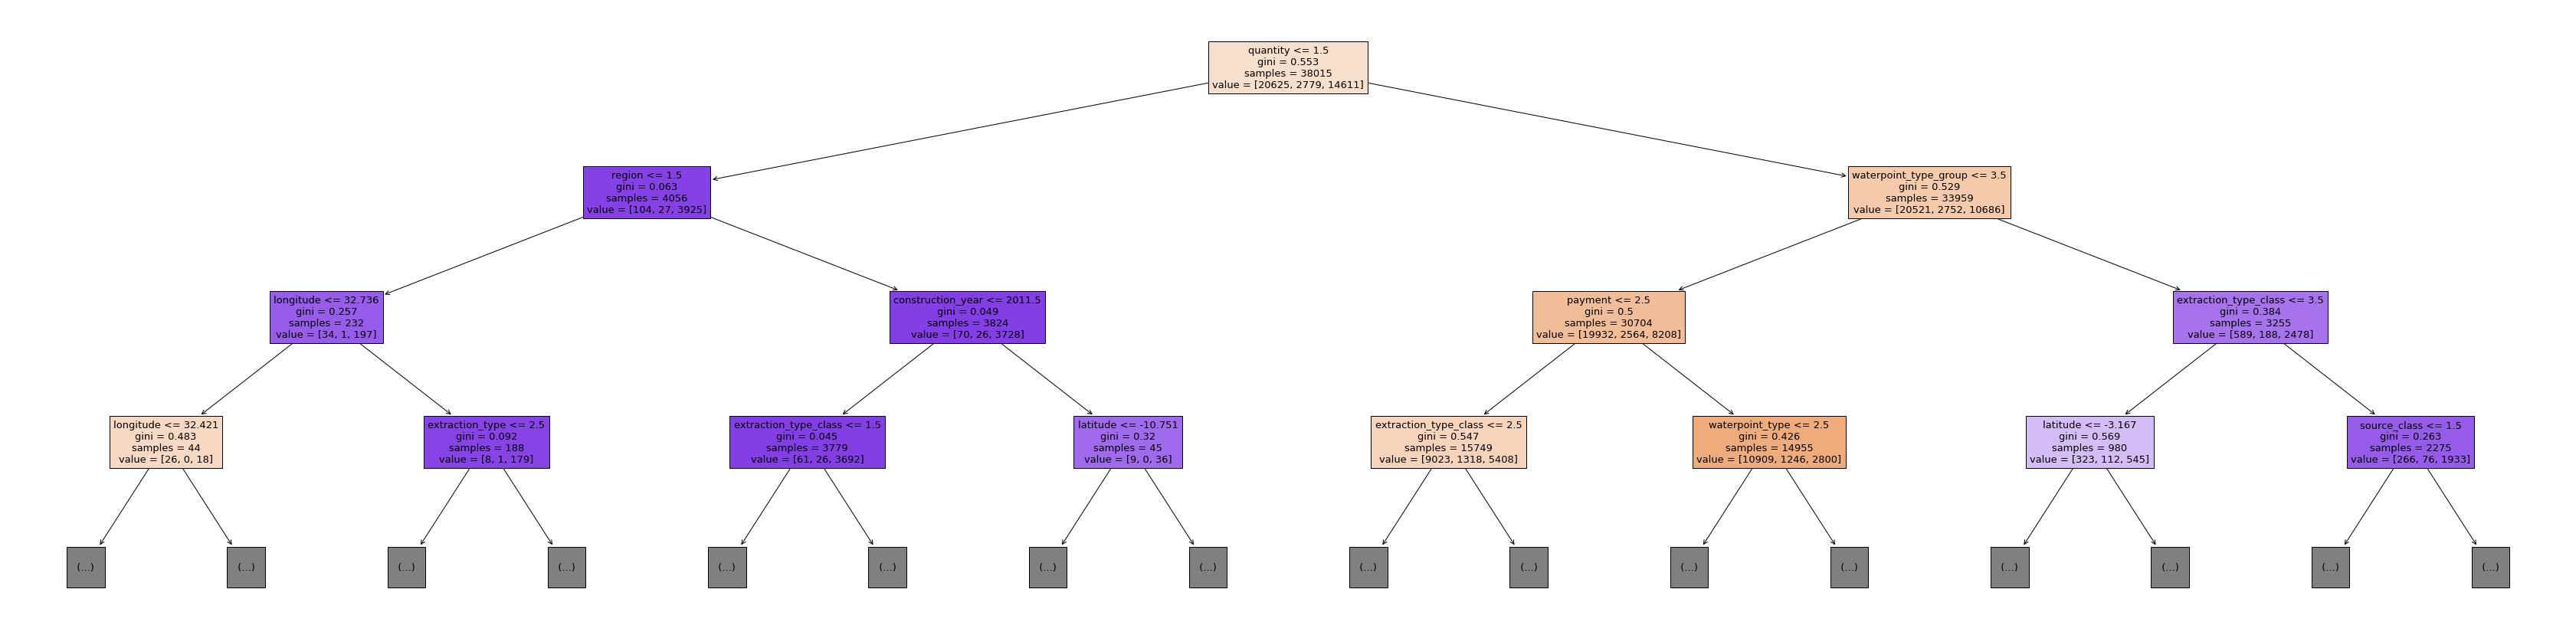

In [ ]:
plt.figure(figsize= (60, 15))
plot_tree(model_dt.named_steps['decisiontreeclassifier'], 
          max_depth=3,
          feature_names=X_train.columns,
          filled=True)

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [ ]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.995475470209128
Validation Accuracy Score: 0.7411616161616161


**Insights:**
- The accuracy score of 99.55% for the training set is almost perfect.
- The validation accuracy score of 74.12% is lesser than the training. So, we could say the model is overfit.
- The model generalization isn't great but it's acceptable. 

# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [ ]:
# Depth of the tree
print('Initial depth of the tree:', model_dt.named_steps['decisiontreeclassifier'].get_depth())

Initial depth of the tree: 38


In [ ]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6

depths = range(5, 50, 2)
list(depths)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

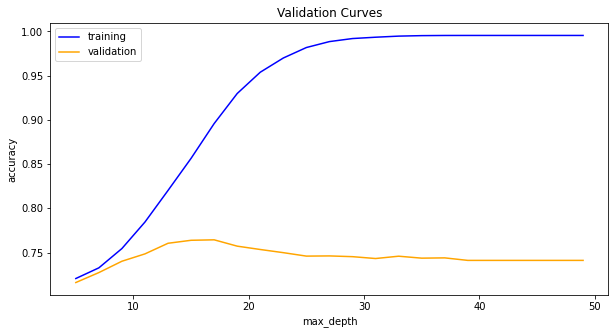

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves')
plt.legend()
plt.show;

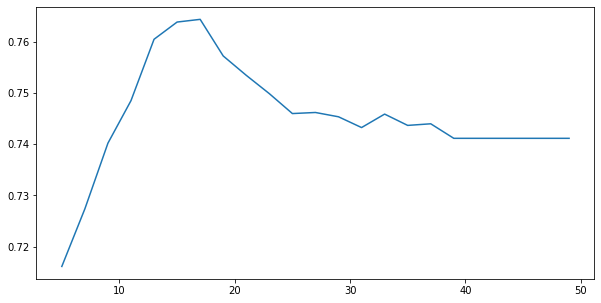

In [ ]:
plt.plot(depths, val_acc);

In [ ]:
# Tuning hyperparameter max_depth and retraining the model
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'mean'),
    DecisionTreeClassifier(max_depth= 17, random_state=42) # max_depth calculated on task 8
)

# Fit the model to the training data
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -

In [ ]:
# Accuracy after tuning the hyperparamenther max depth
# We reduced overfitting and improved the val accuracy score
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8958568985926608
Validation Accuracy Score: 0.7644149831649831


**Insights:**  By tuning one hyperparameter, which in this case was max depth of the tree, we were able to reduce overfitting and increase the generalizability of the model. Our validation has gone up from 74.12% to 76.44%.

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

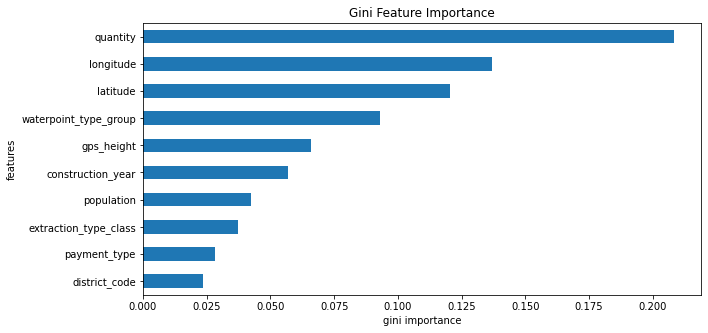

In [ ]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini_importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')
plt.title('Gini Feature Importance');

**Insigths:** According to this plot, the most important feature that helped the model make a prediction about the water pump status, was quantity. 

In [ ]:
# Kaggle Submission
predictions = pd.DataFrame(data=model_dt.predict(X_test), index=X_test.index)

In [ ]:
predictions.columns = ['status_group']

In [ ]:
predictions

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,functional
47083,functional
...,...
26092,functional
919,non functional
47444,non functional


In [ ]:
# Generate CSV file
predictions.to_csv('first_submission.csv')

# Download CSV file
from google.colab import files
files.download('first_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>